### CMPE 252 : Artificial Intelligence and Data Engineering [Spring 2023]
### Home Assignment 3, Part 2 - LQR
### Sequential Decision Making in Linear Models with Quadratic Reward


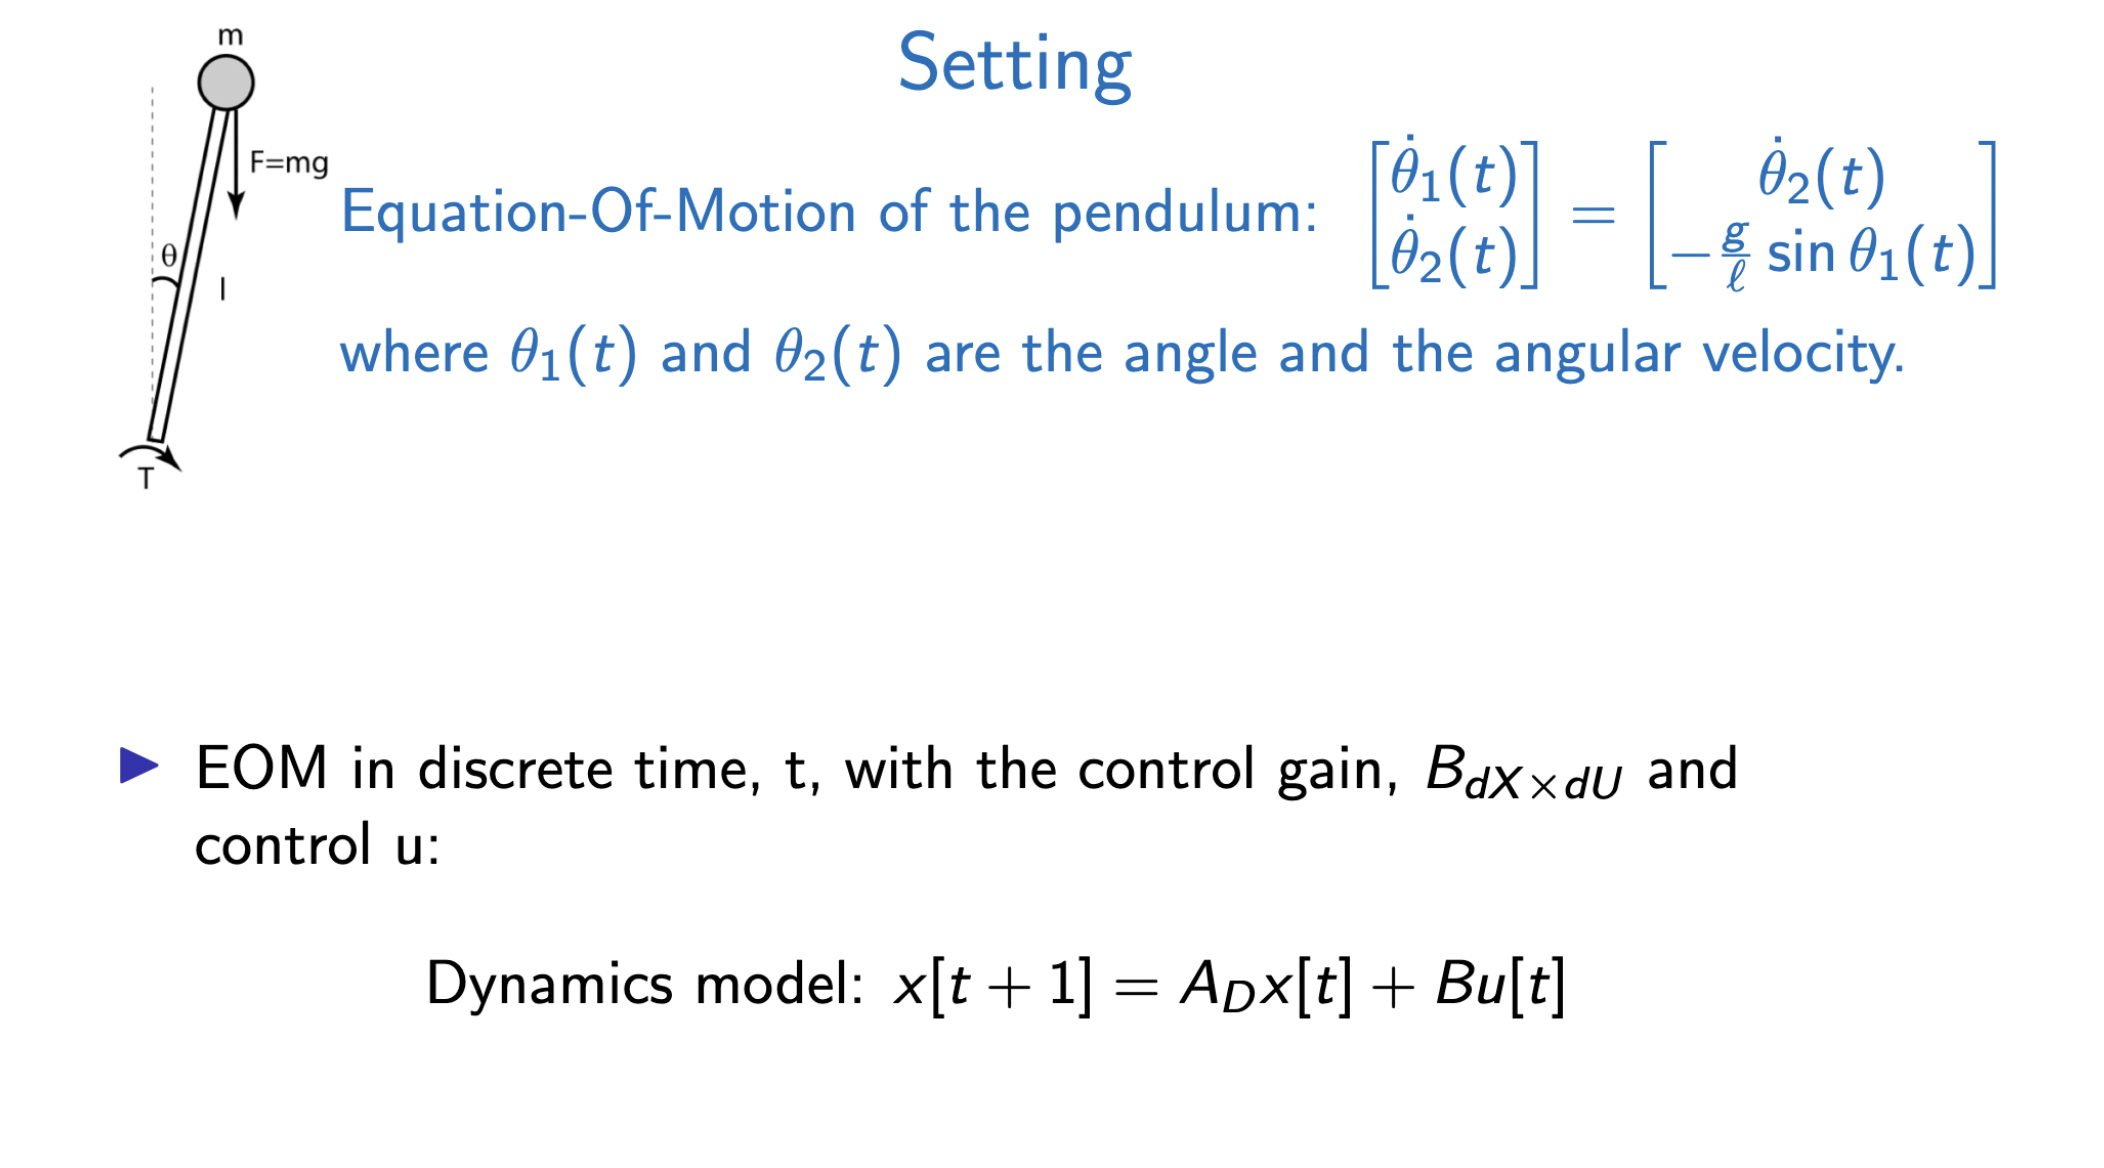

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib inline

In [73]:
# Initialise variable values

AD = np.array([[1.00049, 0.0100016], [0.098016, 1.00049]])
B = np.array([[0.01], [0.0005]])

x0_1 = np.array([[0.1], [0.0]]) # initial state
x0_2 = np.array([[-0.1], [0.0]]) # initial state

T = 499
time = range(1, T+1)

In [74]:
#Dynamics Model
dynamics = lambda x, u : np.matmul(AD, x) + B*u

In [75]:
def simulate_pendulum_dynamics(T, x0):

  sim_state = np.empty((2,T))

  x = x0
  u = 0
  for i in range(T):

    x1 = dynamics(x, u)
    
    sim_state[0][i], sim_state[1][i] = x1[0], x1[1]

    x = x1 # assign next state as current state

  return sim_state


In [76]:
#Question 1
simulated_state_1 = simulate_pendulum_dynamics(T, x0_1)

In [77]:
#Question 2
simulated_state_2 = simulate_pendulum_dynamics(T, x0_2)

#####Question 3

```
The pendulum is left free at a small angle without any control signal.
The angle and angular velocity of the pendulum increase in small steps.
As the angle crosses a certain threshold, gravity pulls the pendulum down and it never return to original state.


```



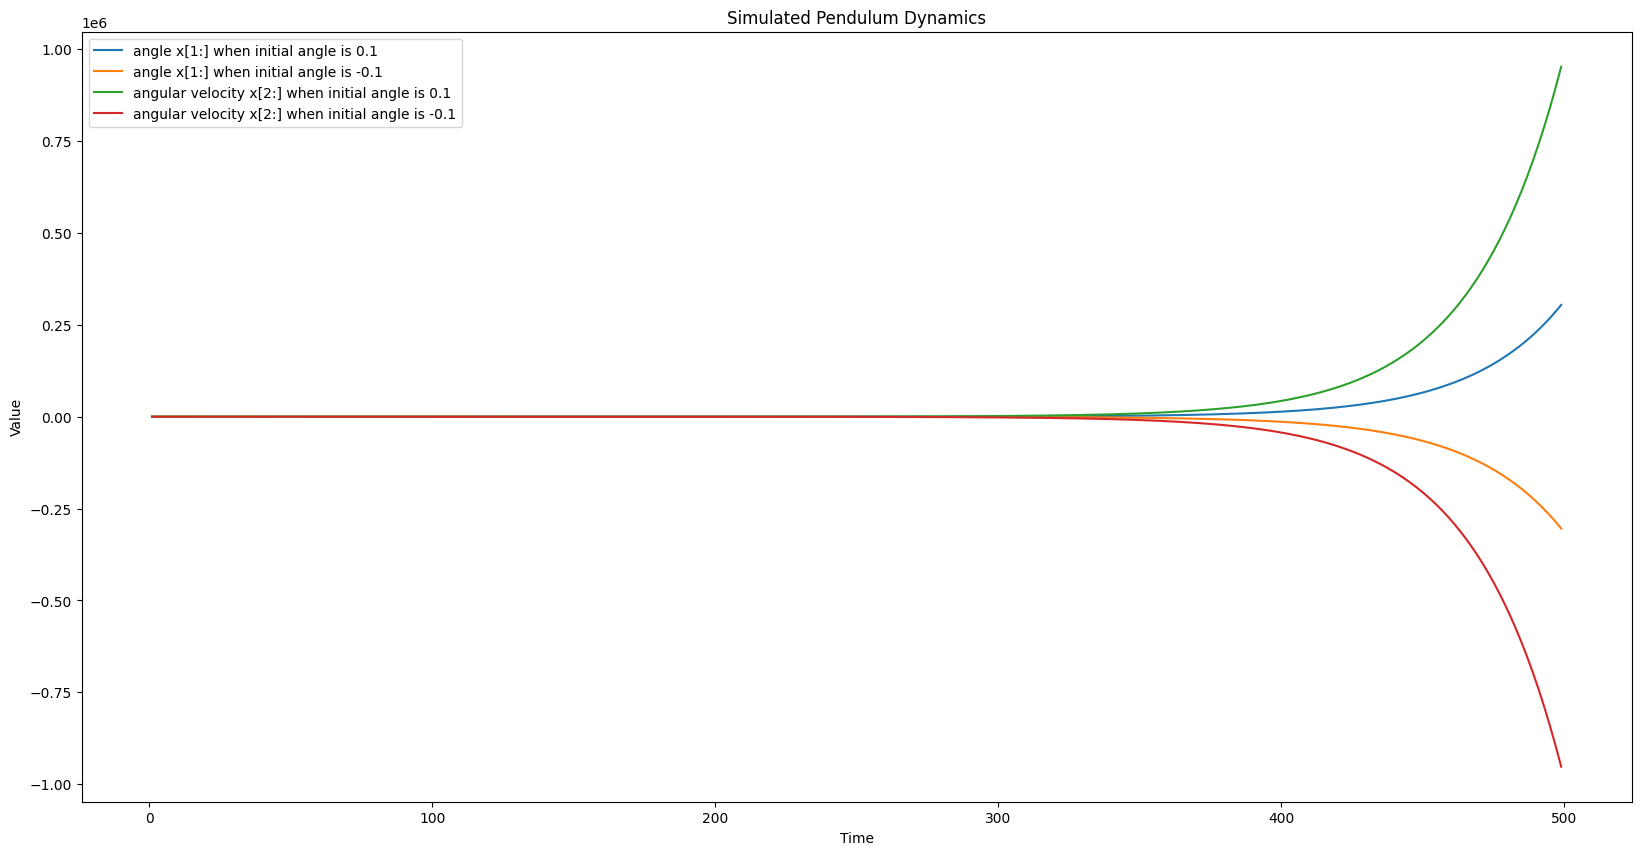

In [78]:
#Question 4
plt.plot(time, simulated_state_1[0][:], label="angle x[1:] when initial angle is 0.1")
plt.plot(time, simulated_state_2[0][:], label="angle x[1:] when initial angle is -0.1 ")
plt.plot(time, simulated_state_1[1][:], label="angular velocity x[2:] when initial angle is 0.1")
plt.plot(time, simulated_state_2[1][:], label="angular velocity x[2:] when initial angle is -0.1")

plt.rcParams['figure.figsize'] = [20, 10]
plt.legend(loc="upper left")
plt.title("Simulated Pendulum Dynamics")
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()

In [79]:
I_2x2 = np.array([[1, 0], [0, 1]])
R = 0.1
ALPHA = [0.001, 5, 10]
A = AD
X0 = [x0_1, x0_2]

In [80]:
def calc_K(alpha):
  Q = alpha * I_2x2

  P = np.empty((T+1, 2, 2))
  K = np.empty((T, 1, 2))

  P[T] = Q # Qf = Q

  for t in range(T, 1, -1):
    t1 = np.transpose(A).dot(P[t]).dot(A)
    t2 = np.transpose(A).dot(P[t]).dot(B)
    t3 = (R + np.transpose(B).dot(P[t]).dot(B))**-1
    t4 = np.transpose(B).dot(P[t]).dot(A)

    P[t-1] = Q + t1 - t2 * t3 * t4
  
  for t in range(T):
    t1 = (R + np.transpose(B).dot(P[t+1]).dot(B))**-1
    t2 = np.transpose(B).dot(P[t+1]).dot(A)

    K[t] =  - t1 * t2

  return P, K


In [81]:
def simulate_pendulum_dynamics_with_state_feedback_control(T, x0, K):

  sim_state = np.empty((2,T))

  x = x0
  for t in range(T):
    u = K[t].dot(x)
    x1 = dynamics(x, u)
    sim_state[0][t], sim_state[1][t] = x1[0], x1[1]
    x = x1 # assign next state as current state

  return sim_state

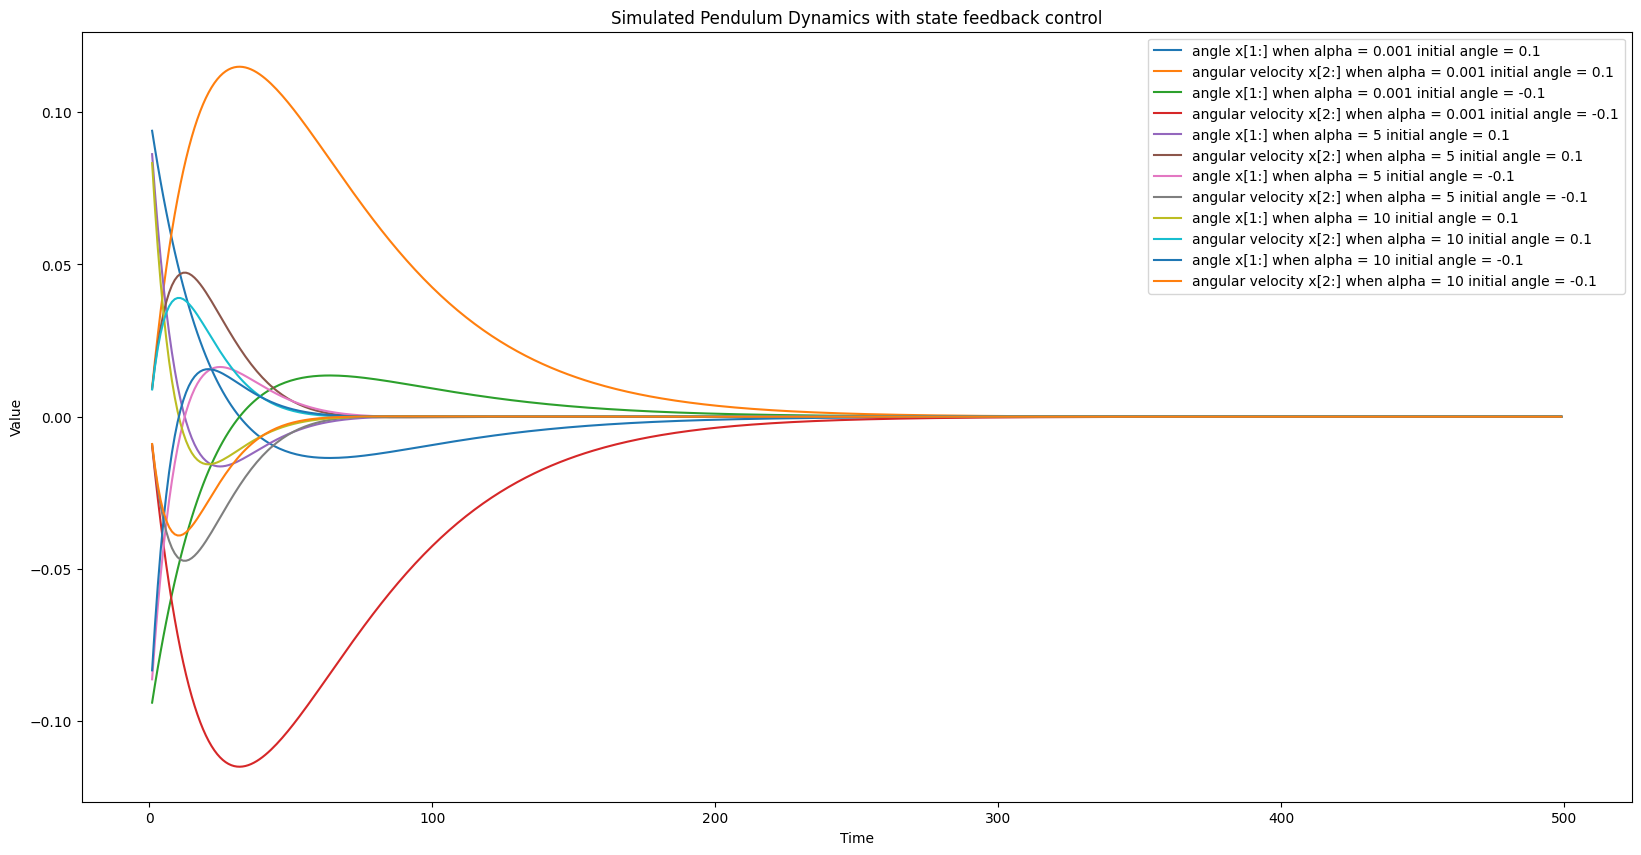

In [82]:
#Question 5

P0 = np.empty((3, 2, 2))

for i, alpha in enumerate(ALPHA):

  P, K = calc_K(alpha)

  #saving for Q6 
  P0[i] = P[1]

  for j, x0 in enumerate(X0):
    simulated_state = simulate_pendulum_dynamics_with_state_feedback_control(T, x0, K)

    plt.plot(time, simulated_state[0][:], label="angle x[1:] when alpha = {} initial angle = {}".format(alpha, x0[0][0]))
    plt.plot(time, simulated_state[1][:], label="angular velocity x[2:] when alpha = {} initial angle = {}".format(alpha, x0[0][0]))


plt.rcParams['figure.figsize'] = [20, 10]
plt.legend(loc="upper right")
plt.title("Simulated Pendulum Dynamics with state feedback control")
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()

As we know, the parameter alpha is used to weigh the relative importance of control input(u) and state error(x) in the cost function. 

A higher value of alpha puts more weight in state error, which means controller reduces deviation from desired state point. 

A lower value of alpha puts more weight on the control input, which means controller will prioritize reducing the control effort.

This is clearly observed in the graph above. 
* For alpha = 0.001, the deviation from the initial state is the most and it takes longer for the pendulum to return to initial state.
* For alpha = 5, the deviation form initial state is more than the previous alpha value and the return to initial is quicker.
* For alpha = 10, the deviation from the intial state is the least, and the pendulum come s back to initial state quickly.

In [83]:
#Question 6

angle = np.arange(-0.3, 0.3 + 0.001, 0.001)
angular_velocity = np.arange(-0.3, 0.3 + 0.001, 0.001)

x_center = 0.5 * (angle[:-1] + angle[1:])
y_center = 0.5 * (angular_velocity[:-1] + angular_velocity[1:])

X, Y = np.meshgrid(x_center, y_center)


def calculate_V(x, y, P0_):
  '''
  P = [a, b; c, d]
  X = [angle ; a.v]
  V = [angle, a.v] [ a, b; c,d] [angle ; a.v] = [anglea + a.vb, anglec + a.vd] [angle; a.v] = angle*(anglea + a.vc) + a.v*( angleb + a.vd)
  '''
  a, b, c, d = P0_[0][0], P0_[0][1], P0_[1][0], P0_[1][1]
  return x*(x*a+y*c) + y*(x*b+y*d)

Value function when α = 0.001

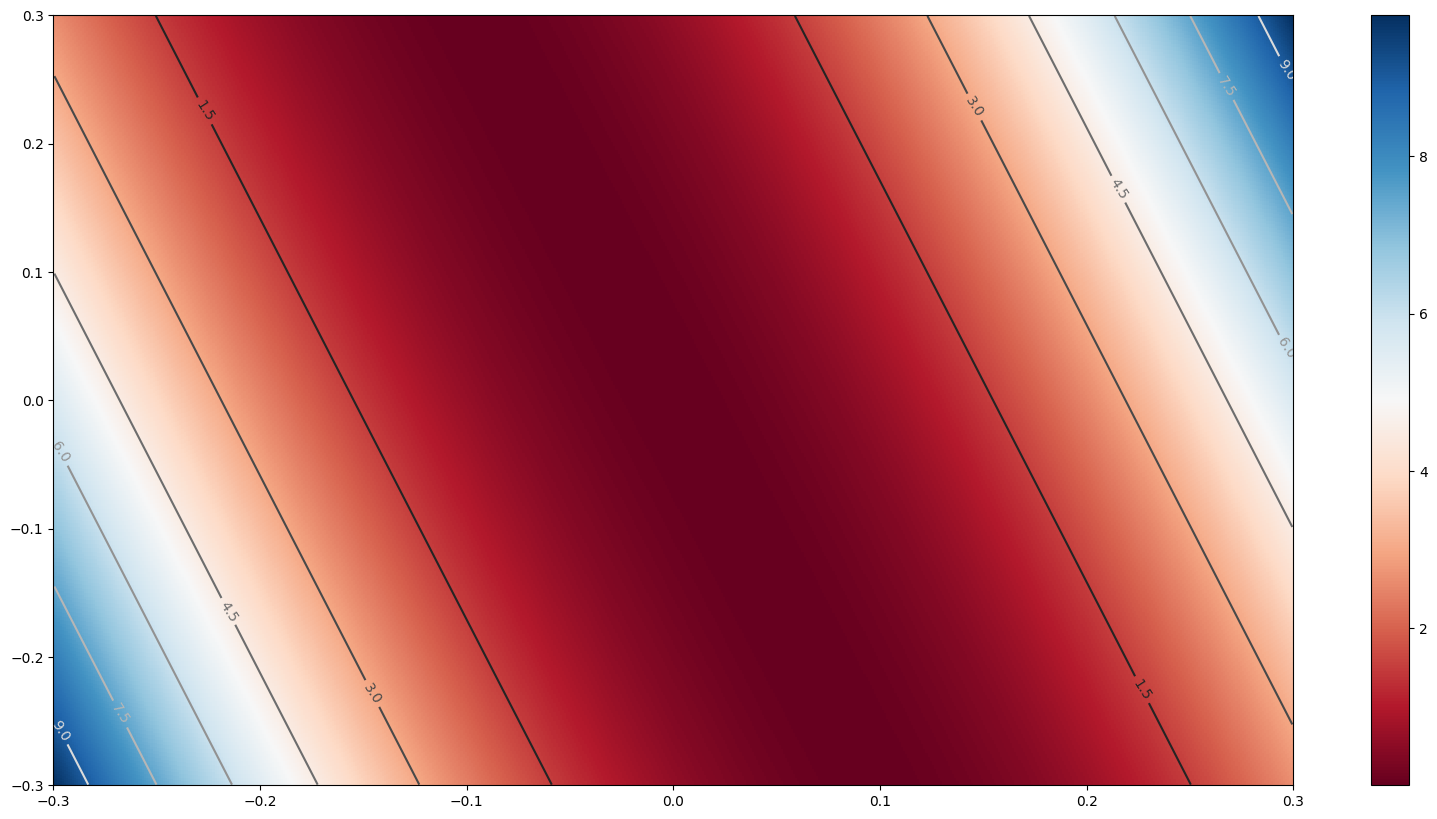

In [84]:
# Value function when α = 0.001
P0_ = P0[0]
V = calculate_V(X, Y, P0_)

plot = plt.pcolormesh(angle, angular_velocity, V, cmap='RdBu', shading='flat')
cset = plt.contour(X, Y, V, cmap='gray')
plt.clabel(cset, inline=True, fmt='%1.1f', fontsize=10)
plt.colorbar(plot)


Value function when α = 5

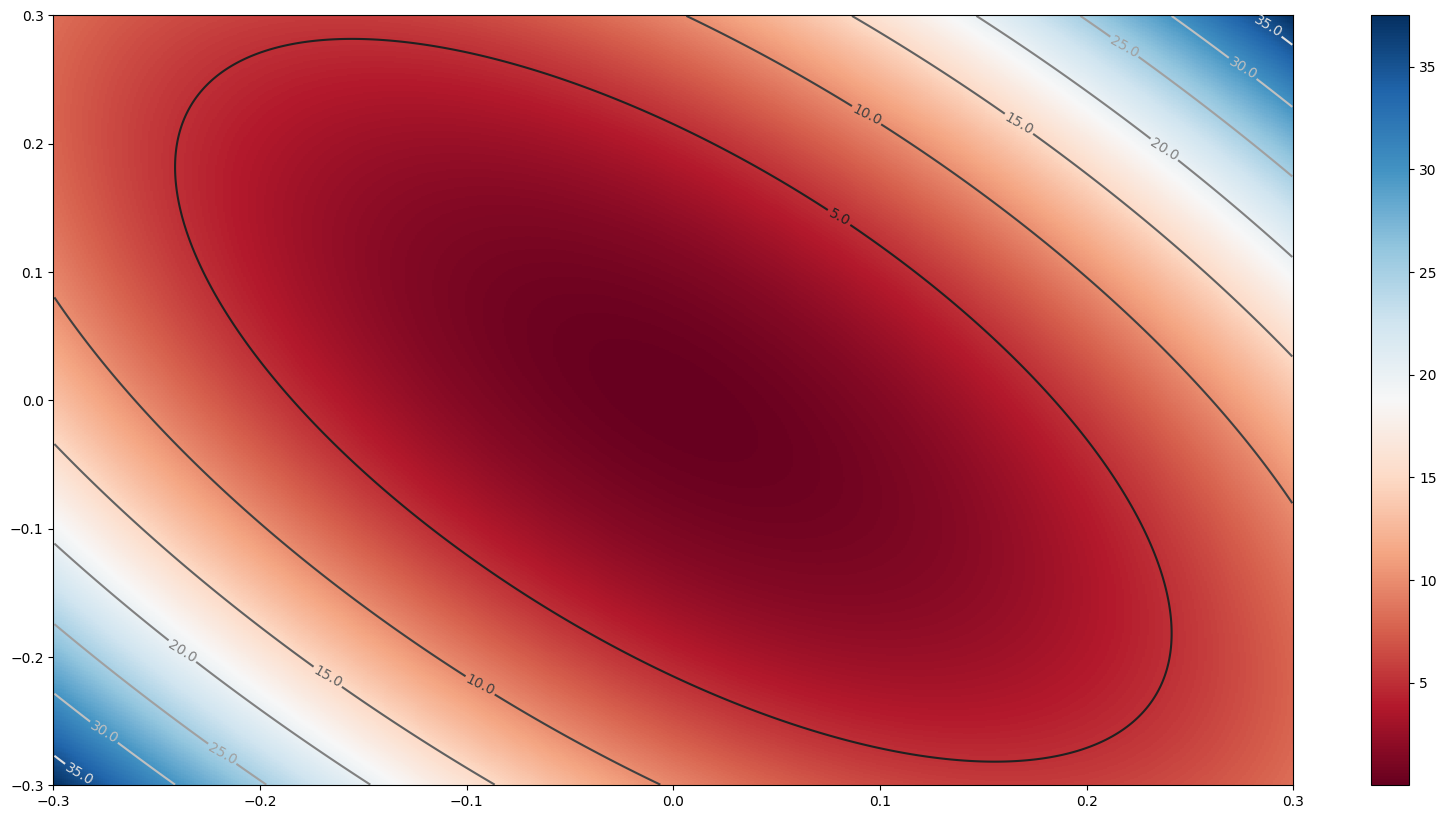

In [85]:
# Value function when α = 5
P0_ = P0[1]
V = calculate_V(X, Y, P0_)

plot = plt.pcolormesh(angle, angular_velocity, V, cmap='RdBu', shading='flat')
cset = plt.contour(X, Y, V, cmap='gray')
plt.clabel(cset, inline=True, fmt='%1.1f', fontsize=10)
plt.colorbar(plot)


Value function when α = 10

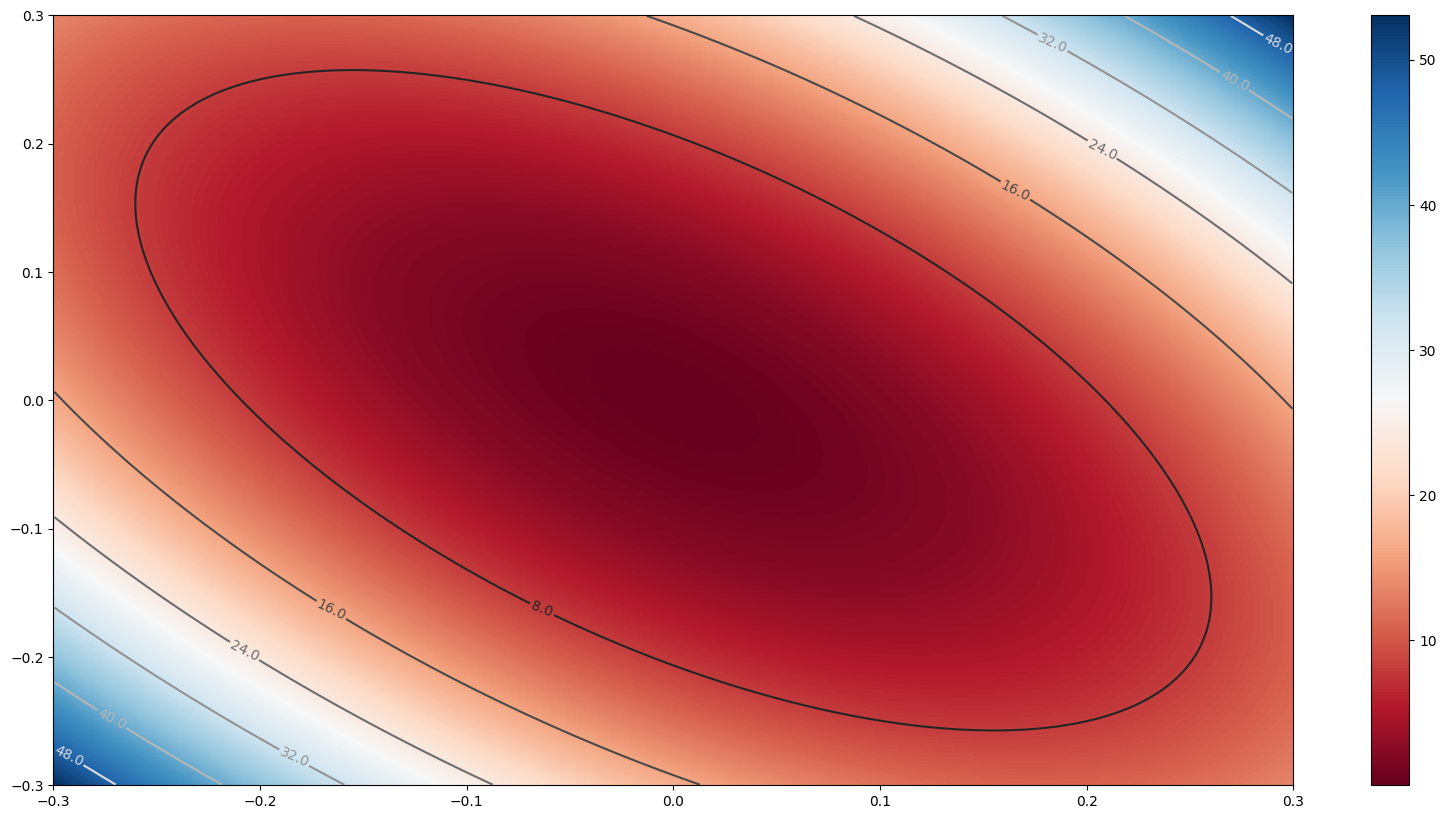

In [86]:
# Value function when α = 10
P0_ = P0[2]
V = calculate_V(X, Y, P0_)

plot = plt.pcolormesh(angle, angular_velocity, V, cmap='RdBu', shading='flat')
cset = plt.contour(X, Y, V, cmap='gray')
plt.clabel(cset, inline=True, fmt='%1.1f', fontsize=10)
plt.colorbar(plot)


Explanations:

Value represents the optimal cost of achieving a desired state.

Higher the value of alpha, lower is the cost of achieving the desired state. Also the red areas in the plots surrounding (0.0, 0.0) represent a lower cost of achieving desired state than the blue area.

The shape of the value plot is an ellipse because value is not a direct function of control signal. Control signal impacts force applied, which impacts angular velocity of the pendulum. The angular velocity of the pendulum directly impacts the value.

At lower alpha, the major axis of the ellipse is long resulting in the stright lines in the plot.